Iñigo Martin Melero

## Participante 5

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_5_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


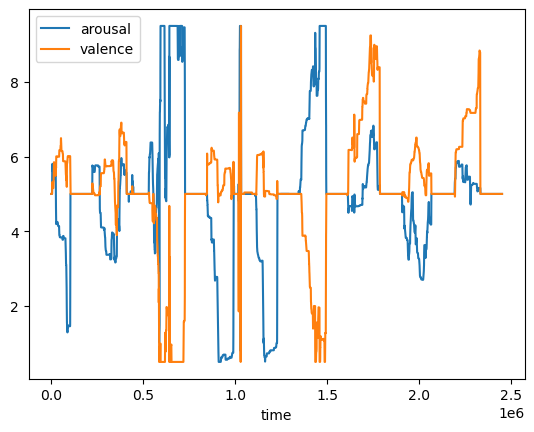

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_5_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.600  35.925  30.685  43.397  32.492     7.535     6.836   
1              1  0.613  35.761  30.760  43.407  32.492     7.617     6.960   
2              2  0.626  35.596  30.835  43.417  32.492     7.699     7.083   
3              3  0.623  35.557  30.839  43.426  32.499     7.617     7.083   
4              4  0.659  35.761  30.811  43.484  32.506     7.740     7.083   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  1.119  31.712  37.703  43.775  34.743     5.153     5.604   
2451580  2451580  1.106  31.828  37.770  43.794  34.750     5.112     5.563   
2451581  2451581  1.106  31.121  37.774  43.823  34.764     5.235     5.727   
2451582  2451582  1.079  31.392  37.770  43.794  34.753     5.112     5.604   
2451583  2451583  1.083  31.654  37.770  43.794  34.757     5.153     5.645   

         emg_trap  video  
0          13.038     10

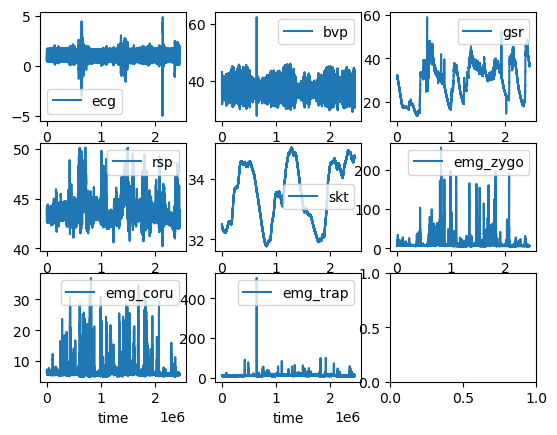

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

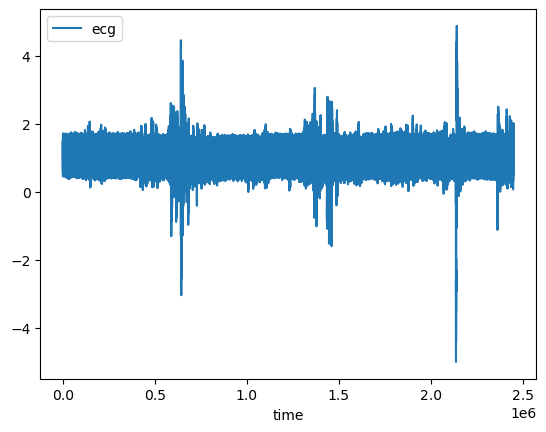

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

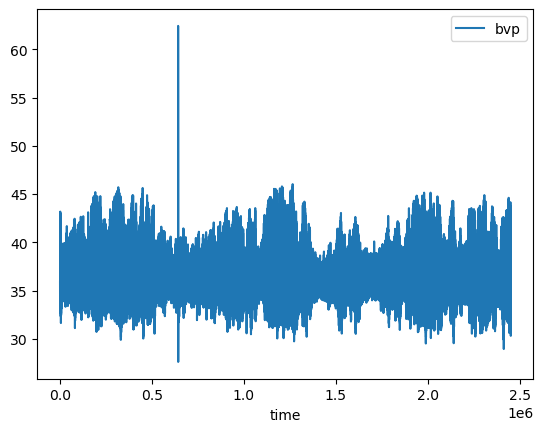

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

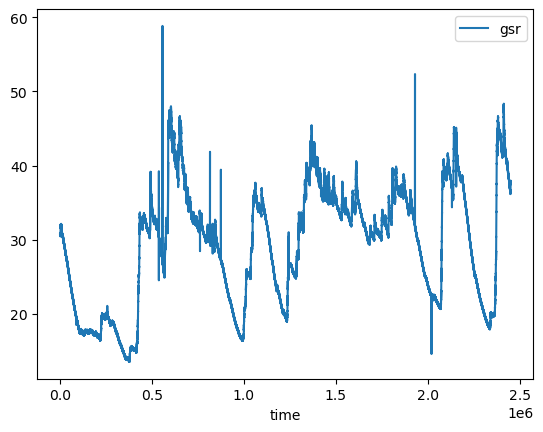

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

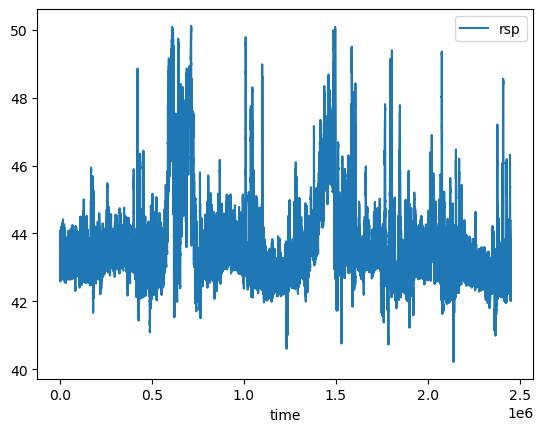

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

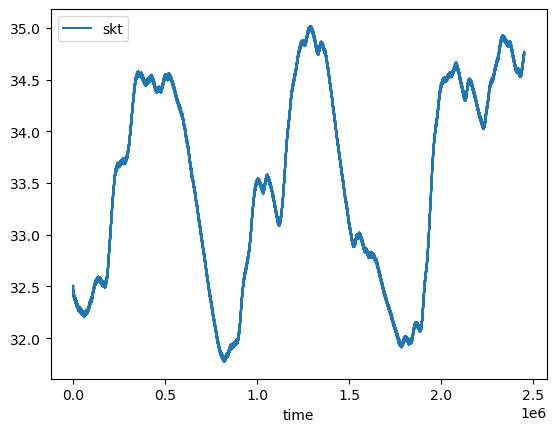

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

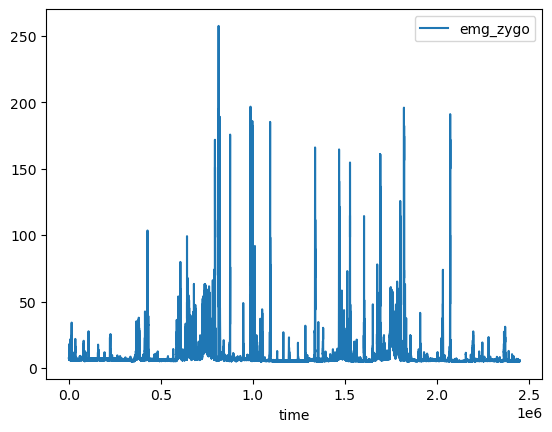

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

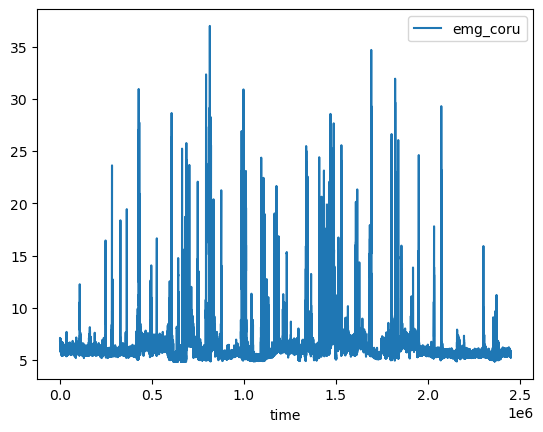

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

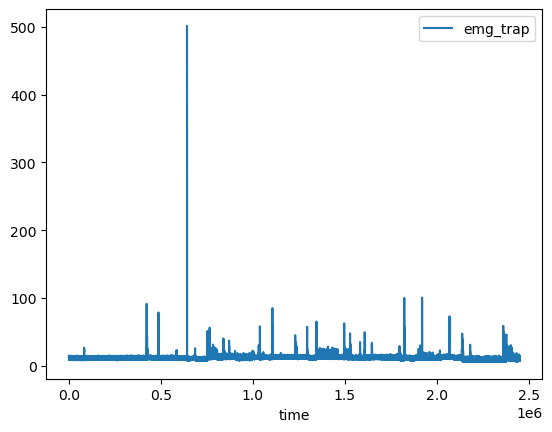

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

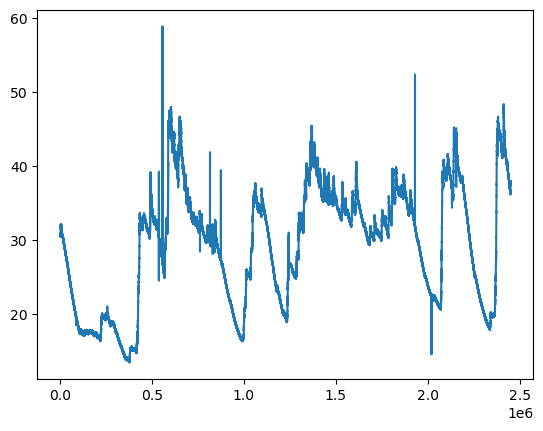

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

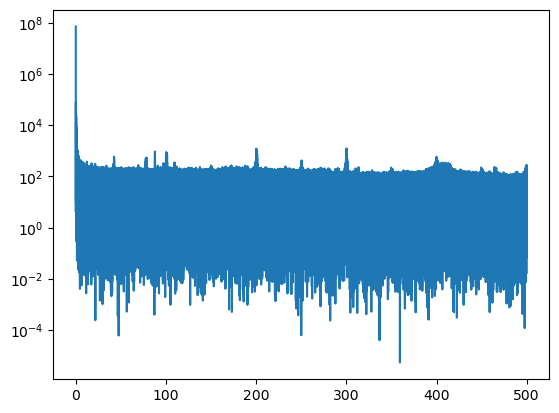

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

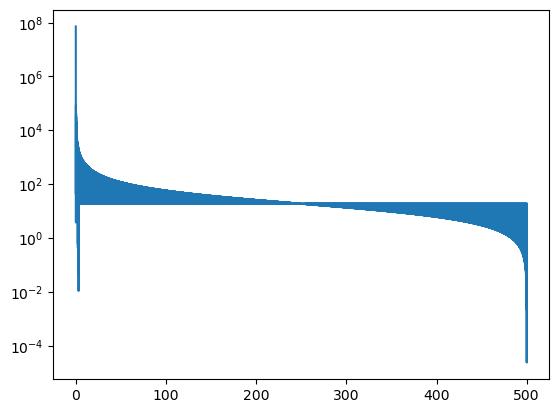

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

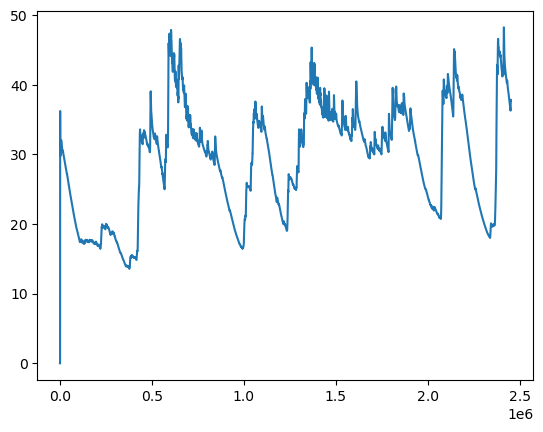

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  37.737
2451580  37.736
2451581  37.736
2451582  37.736
2451583  37.736

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

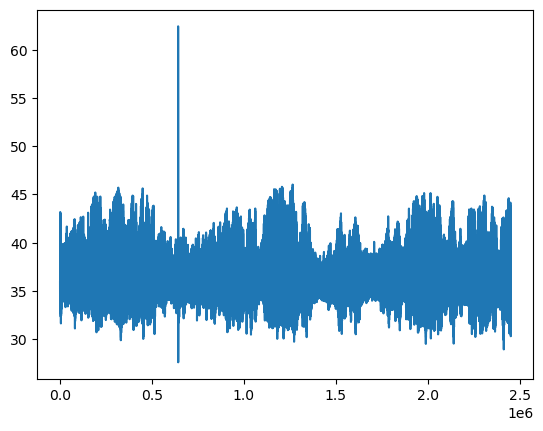

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

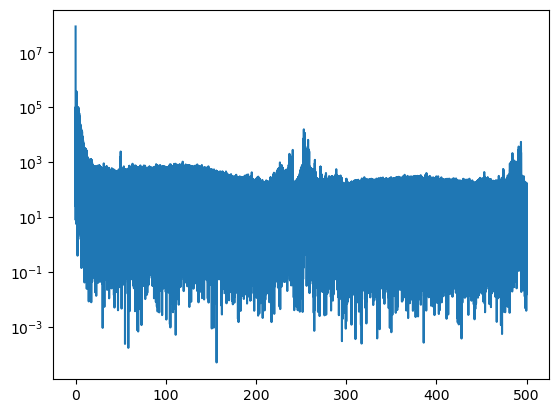

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

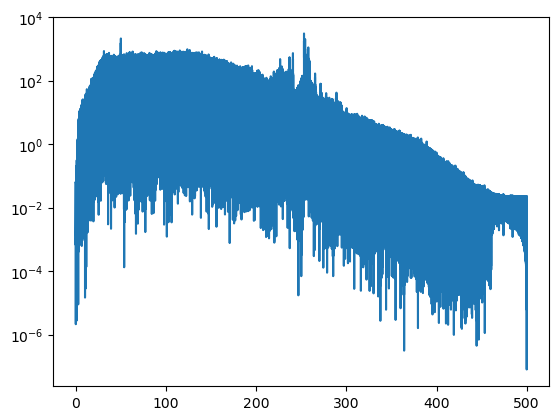

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

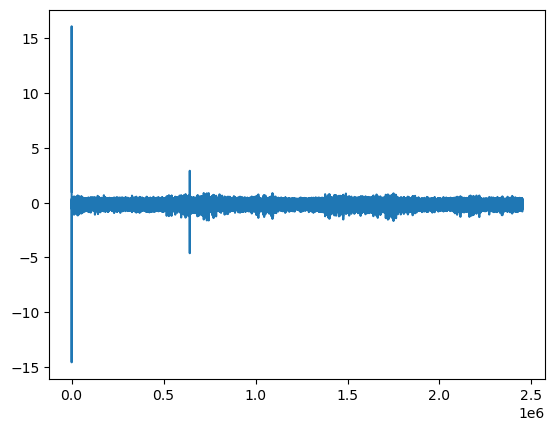

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        37.998
1        42.564
2        50.072
3        53.114
4        45.927
...         ...
2451579  37.109
2451580  37.075
2451581  37.096
2451582  37.120
2451583  37.031

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

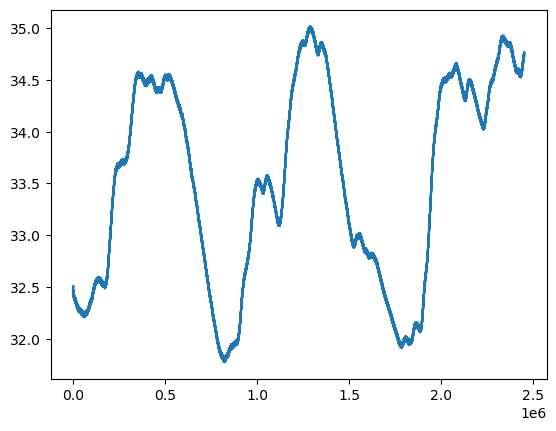

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

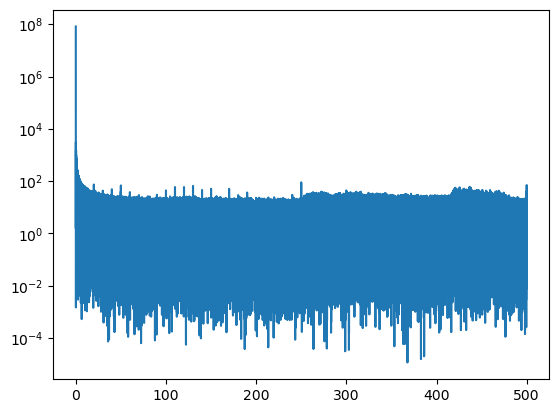

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

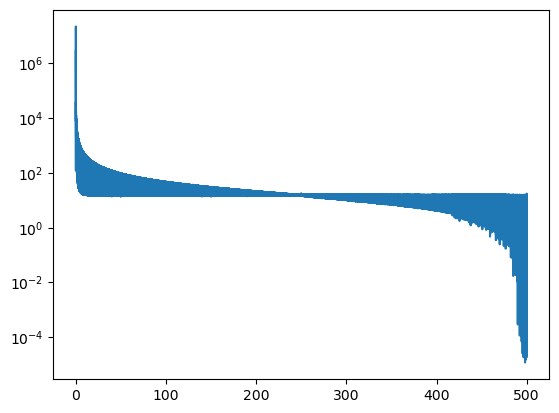

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

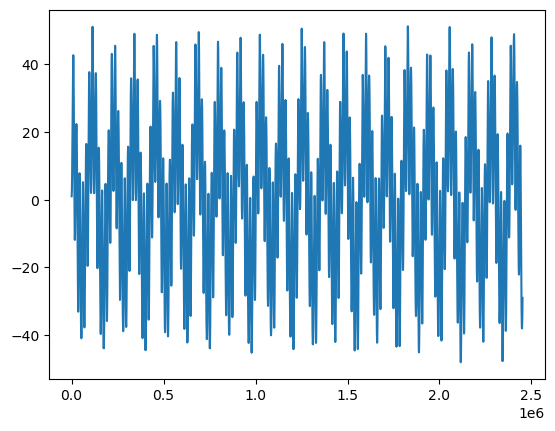

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        41.041
1        41.041
2        41.041
3        41.041
4        41.042
...         ...
2451579  10.962
2451580  10.967
2451581  10.973
2451582  10.978
2451583  10.983

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.600  43.397     7.535     6.836    13.038     10
1              1  0.613  43.407     7.617     6.960    13.202     10
2              2  0.626  43.417     7.699     7.083    13.366     10
3              3  0.623  43.426     7.617     7.083    13.284     10
4              4  0.659  43.484     7.740     7.083    13.490     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  1.119  43.775     5.153     5.604    13.079     12
2451580  2451580  1.106  43.794     5.112     5.563    12.873     12
2451581  2451581  1.106  43.823     5.235     5.727    12.873     12
2451582  2451582  1.079  43.794     5.112     5.604    12.709     12
2451583  2451583  1.083  43.794     5.153     5.645    12.545     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.600  43.397     7.535     6.836    13.038     10  37.998   
1              1  0.613  43.407     7.617     6.960    13.202     10  42.564   
2              2  0.626  43.417     7.699     7.083    13.366     10  50.072   
3              3  0.623  43.426     7.617     7.083    13.284     10  53.114   
4              4  0.659  43.484     7.740     7.083    13.490     10  45.927   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  1.119  43.775     5.153     5.604    13.079     12  37.109   
2451580  2451580  1.106  43.794     5.112     5.563    12.873     12  37.075   
2451581  2451581  1.106  43.823     5.235     5.727    12.873     12  37.096   
2451582  2451582  1.079  43.794     5.112     5.604    12.709     12  37.120   
2451583  2451583  1.083  43.794     5.153     5.645    12.545     12  37.031   

            gsr     skt  
0         0.000  41.041  
1         0.000  41.041  
2         0.000  41.041  
3         0.000  41.041  
4         0.000  41.042  
...         ...     ...  
2451579  37.737  10.962  
2451580  37.736  10.967  
2451581  37.736  10.973  
2451582  37.736  10.978  
2451583  37.736  10.983  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.497330  0.621600  0.093684  0.778638  0.227091  0.008333   
221502    221502  0.495995  0.612976  0.093684  0.778566  0.228203  0.008333   
221503    221503  0.494259  0.614701  0.093714  0.778493  0.231428  0.009192   
221504    221504  0.494793  0.616824  0.093714  0.778410  0.224978  0.007907   
221505    221505  0.498264  0.604883  0.093714  0.778337  0.233541  0.008547   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.496929  0.622131  0.136703  0.334337  0.117327  0.005556   
2331580  2331580  0.495594  0.614170  0.136703  0.334420  0.110876  0.005342   
2331581  2331581  0.493858  0.618150  0.136703  0.334503  0.115102  0.005342   
2331582  2331582  0.492123  0.622927  0.136703  0.334576  0.111877  0.004916   
2331583  2331583  0.494259  0.614303  0.136703  0.334659  0.112989  0.005769   

         emg_coru  emg_trap  video  
221501   0.027498  0.006710      1  
221502   0.027498  0.006627      1  
221503   0.031617  0.006958      1  
221504   0.024751  0.006627      1  
221505   0.028904  0.006627      1  
...           ...       ...    ...  
2331579  0.026125  0.002319      6  
2331580  0.026125  0.002154      6  
2331581  0.027498  0.002319      6  
2331582  0.024751  0.002154      6  
2331583  0.027498  0.002154      6  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.497330  0.621600  0.093684  0.227091  0.778638  0.008333   
221502    221502  0.495995  0.612976  0.093684  0.228203  0.778566  0.008333   
221503    221503  0.494259  0.614701  0.093714  0.231428  0.778493  0.009192   
221504    221504  0.494793  0.616824  0.093714  0.224978  0.778410  0.007907   
221505    221505  0.498264  0.604883  0.093714  0.233541  0.778337  0.008547   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.496929  0.622131  0.136703  0.117327  0.334337  0.005556   
2331580  2331580  0.495594  0.614170  0.136703  0.110876  0.334420  0.005342   
2331581  2331581  0.493858  0.618150  0.136703  0.115102  0.334503  0.005342   
2331582  2331582  0.492123  0.622927  0.136703  0.111877  0.334576  0.004916   
2331583  2331583  0.494259  0.614303  0.136703  0.112989  0.334659  0.005769   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.495995  0.612180  0.093772  0.221753  0.777226  0.007694  0.027498   
221540   0.523231  0.623060  0.093859  0.223866  0.775741  0.009831  0.033024   
221560   0.618825  0.608996  0.093947  0.219528  0.774246  0.010685  0.030244   
221580   0.493858  0.624121  0.094035  0.219528  0.772751  0.010045  0.038517   
221600   0.518425  0.609792  0.094151  0.216303  0.771256  0.008333  0.035771   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.496929  0.618681  0.136762  0.110876  0.328013  0.004276  0.023378   
2331520  0.493858  0.610190  0.136762  0.110876  0.329612  0.004276  0.022005   
2331540  0.494793  0.604883  0.136732  0.110876  0.331222  0.004916  0.023378   
2331560  0.494793  0.607271  0.136732  0.116214  0.332821  0.005129  0.020632   
2331580  0.495594  0.614170  0.136703  0.110876  0.334420  0.005342  0.026125   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.495995  0.612180  0.093772  0.221753  0.777226  0.007694  0.027498   
1      0.523231  0.623060  0.093859  0.223866  0.775741  0.009831  0.033024   
2      0.618825  0.608996  0.093947  0.219528  0.774246  0.010685  0.030244   
3      0.493858  0.624121  0.094035  0.219528  0.772751  0.010045  0.038517   
4      0.518425  0.609792  0.094151  0.216303  0.771256  0.008333  0.035771   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.496929  0.618681  0.136762  0.110876  0.328013  0.004276  0.023378   
63500  0.493858  0.610190  0.136762  0.110876  0.329612  0.004276  0.022005   
63501  0.494793  0.604883  0.136732  0.110876  0.331222  0.004916  0.023378   
63502  0.494793  0.607271  0.136732  0.116214  0.332821  0.005129  0.020632   
63503  0.495594  0.614170  0.136703  0.110876  0.334420  0.005342  0.026125   

       emg_trap  valence  arousal  
0      0.006710    5.000     5.00  
1      0.007040    5.000     5.00  
2      0.007040    5.000     5.00  
3      0.009690    5.000     5.00  
4      0.013252    5.000     5.00  
...         ...      ...      ...  
63499  0.002237    8.795     5.16  
63500  0.002071    8.795     5.16  
63501  0.001988    8.796     5.16  
63502  0.002071    8.797     5.16  
63503  0.002154    8.796     5.16  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.495995  0.612180  0.093772  0.221753  0.777226  0.007694  0.027498   
1      0.523231  0.623060  0.093859  0.223866  0.775741  0.009831  0.033024   
2      0.618825  0.608996  0.093947  0.219528  0.774246  0.010685  0.030244   
3      0.493858  0.624121  0.094035  0.219528  0.772751  0.010045  0.038517   
4      0.518425  0.609792  0.094151  0.216303  0.771256  0.008333  0.035771   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.500935  0.627703  0.136849  0.111877  0.321575  0.003849  0.027498   
63496  0.501736  0.611915  0.136820  0.111877  0.323195  0.004276  0.028904   
63497  0.500935  0.614435  0.136791  0.112989  0.324805  0.005129  0.031617   
63498  0.496929  0.618416  0.136791  0.110876  0.326404  0.004489  0.024751   
63499  0.496929  0.618681  0.136762  0.110876  0.328013  0.004276  0.023378   

       emg_trap  valence  arousal  
0      0.006710    5.000     5.00  
1      0.007040    5.000     5.00  
2      0.007040    5.000     5.00  
3      0.009690    5.000     5.00  
4      0.013252    5.000     5.00  
...         ...      ...      ...  
63495  0.001492    8.795     5.16  
63496  0.001906    8.796     5.16  
63497  0.001988    8.797     5.16  
63498  0.001823    8.796     5.16  
63499  0.002237    8.795     5.16  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.495995  0.612180  0.093772  0.221753  0.777226  0.007694  0.027498   
 1   0.523231  0.623060  0.093859  0.223866  0.775741  0.009831  0.033024   
 2   0.618825  0.608996  0.093947  0.219528  0.774246  0.010685  0.030244   
 3   0.493858  0.624121  0.094035  0.219528  0.772751  0.010045  0.038517   
 4   0.518425  0.609792  0.094151  0.216303  0.771256  0.008333  0.035771   
 5   0.521095  0.622529  0.094239  0.217415  0.769771  0.008760  0.035771   
 6   0.529372  0.621600  0.094326  0.217415  0.768265  0.008547  0.038517   
 7   0.549533  0.615364  0.094443  0.217415  0.766759  0.007694  0.033024   
 8   0.523632  0.601964  0.094560  0.213078  0.765264  0.008333  0.031617   
 9   0.543925  0.616426  0.094677  0.210965  0.763759  0.009400  0.033024   
 10  0.555674  0.618947  0.094793  0.207740  0.762242  0.009192  0.034397   
 11  0.571562  0.619212  0.094910  0.210965  0.760737  0.008333  0.034397   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.495995  0.612180  0.093772  0.221753  0.777226  0.007694  0.027498   
1     0.504806  0.620008  0.096953  0.178603  0.739492  0.008547  0.037144   
2     0.518825  0.616956  0.101769  0.179715  0.701539  0.012183  0.028904   
3     0.503471  0.603954  0.111195  0.215191  0.664614  0.011538  0.022005   
4     0.565821  0.600504  0.119572  0.295930  0.629839  0.019871  0.033024   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.500935  0.610455  0.140556  0.179715  0.149703  0.003423  0.024751   
2536  0.500935  0.586706  0.140205  0.256117  0.178788  0.004489  0.022005   
2537  0.495594  0.624519  0.139447  0.205516  0.212504  0.004276  0.027498   
2538  0.504005  0.614435  0.138513  0.136677  0.249792  0.004489  0.027498   
2539  0.593858  0.609924  0.137783  0.127002  0.289344  0.004276  0.030244   

             8         9        10  ...       193       194       195  \
0     0.006710  0.523231  0.623060  ...  0.510547  0.624784  0.096807   
1     0.006129  0.502670  0.620406  ...  0.495995  0.602096  0.101477   
2     0.006461  0.603071  0.619079  ...  0.504806  0.619212  0.110845   
3     0.006461  0.501335  0.615895  ...  0.564085  0.621335  0.119251   
4     0.007704  0.475434  0.612180  ...  0.496929  0.617487  0.127977   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.001077  0.492924  0.646544  ...  0.500000  0.614701  0.140235   
2536  0.000829  0.502670  0.637389  ...  0.490788  0.608332  0.139505   
2537  0.001492  0.548198  0.610588  ...  0.504806  0.622264  0.138513   
2538  0.000829  0.500401  0.607802  ...  0.528972  0.608332  0.137841   
2539  0.001658  0.464887  0.624254  ...  0.496929  0.618681  0.136762   

           196       197       198       199       200  valence  arousal  
0     0.180827  0.741018  0.008973  0.034397  0.006461  5.00000   5.0000  
1     0.179715  0.703034  0.008760  0.028904  0.006213  5.00000   5.0000  
2     0.208741  0.666057  0.010898  0.024751  0.006792  5.00000   5.0000  
3     0.302491  0.631178  0.020084  0.030244  0.006461  5.00000   5.0132  
4     0.225979  0.599279  0.013676  0.020632  0.006875  5.09712   5.3994  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.257229  0.177542  0.004916  0.026125  0.000994  8.84104   5.1600  
2536  0.210965  0.211082  0.005129  0.028904  0.001244  8.83924   5.1600  
2537  0.137789  0.248256  0.004702  0.033024  0.000829  8.82856   5.1600  
2538  0.129115  0.287735  0.003849  0.027498  0.001160  8.81168   5.1600  
2539  0.110876  0.328013  0.004276  0.023378  0.002237  8.79856   5.1600  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.495995  0.612180  0.093772  0.221753  0.777226  0.007694  0.027498   
1     0.504806  0.620008  0.096953  0.178603  0.739492  0.008547  0.037144   
2     0.518825  0.616956  0.101769  0.179715  0.701539  0.012183  0.028904   
3     0.503471  0.603954  0.111195  0.215191  0.664614  0.011538  0.022005   
4     0.565821  0.600504  0.119572  0.295930  0.629839  0.019871  0.033024   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.500935  0.610455  0.140556  0.179715  0.149703  0.003423  0.024751   
2536  0.500935  0.586706  0.140205  0.256117  0.178788  0.004489  0.022005   
2537  0.495594  0.624519  0.139447  0.205516  0.212504  0.004276  0.027498   
2538  0.504005  0.614435  0.138513  0.136677  0.249792  0.004489  0.027498   
2539  0.593858  0.609924  0.137783  0.127002  0.289344  0.004276  0.030244   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub5.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.495995  0.612180  0.093772  0.221753  0.777226  0.007694  0.027498   
1     0.504806  0.620008  0.096953  0.178603  0.739492  0.008547  0.037144   
2     0.518825  0.616956  0.101769  0.179715  0.701539  0.012183  0.028904   
3     0.503471  0.603954  0.111195  0.215191  0.664614  0.011538  0.022005   
4     0.565821  0.600504  0.119572  0.295930  0.629839  0.019871  0.033024   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.500935  0.610455  0.140556  0.179715  0.149703  0.003423  0.024751   
2536  0.500935  0.586706  0.140205  0.256117  0.178788  0.004489  0.022005   
2537  0.495594  0.624519  0.139447  0.205516  0.212504  0.004276  0.027498   
2538  0.504005  0.614435  0.138513  0.136677  0.249792  0.004489  0.027498   
2539  0.593858  0.609924  0.137783  0.127002  0.289344  0.004276  0.030244   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub5.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.495995  0.612180  0.093772  0.221753  0.777226  0.007694  0.027498   
1     0.504806  0.620008  0.096953  0.178603  0.739492  0.008547  0.037144   
2     0.518825  0.616956  0.101769  0.179715  0.701539  0.012183  0.028904   
3     0.503471  0.603954  0.111195  0.215191  0.664614  0.011538  0.022005   
4     0.565821  0.600504  0.119572  0.295930  0.629839  0.019871  0.033024   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.500935  0.610455  0.140556  0.179715  0.149703  0.003423  0.024751   
2536  0.500935  0.586706  0.140205  0.256117  0.178788  0.004489  0.022005   
2537  0.495594  0.624519  0.139447  0.205516  0.212504  0.004276  0.027498   
2538  0.504005  0.614435  0.138513  0.136677  0.249792  0.004489  0.027498   
2539  0.593858  0.609924  0.137783  0.127002  0.289344  0.004276  0.030244   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub5.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.495995  0.612180  0.093772  0.221753  0.777226  0.007694  0.027498   
1     0.504806  0.620008  0.096953  0.178603  0.739492  0.008547  0.037144   
2     0.518825  0.616956  0.101769  0.179715  0.701539  0.012183  0.028904   
3     0.503471  0.603954  0.111195  0.215191  0.664614  0.011538  0.022005   
4     0.565821  0.600504  0.119572  0.295930  0.629839  0.019871  0.033024   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.500935  0.610455  0.140556  0.179715  0.149703  0.003423  0.024751   
2536  0.500935  0.586706  0.140205  0.256117  0.178788  0.004489  0.022005   
2537  0.495594  0.624519  0.139447  0.205516  0.212504  0.004276  0.027498   
2538  0.504005  0.614435  0.138513  0.136677  0.249792  0.004489  0.027498   
2539  0.593858  0.609924  0.137783  0.127002  0.289344  0.004276  0.030244   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub5.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.495995  0.612180  0.093772  0.221753  0.777226  0.007694  0.027498   
1     0.504806  0.620008  0.096953  0.178603  0.739492  0.008547  0.037144   
2     0.518825  0.616956  0.101769  0.179715  0.701539  0.012183  0.028904   
3     0.503471  0.603954  0.111195  0.215191  0.664614  0.011538  0.022005   
4     0.565821  0.600504  0.119572  0.295930  0.629839  0.019871  0.033024   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.500935  0.610455  0.140556  0.179715  0.149703  0.003423  0.024751   
2536  0.500935  0.586706  0.140205  0.256117  0.178788  0.004489  0.022005   
2537  0.495594  0.624519  0.139447  0.205516  0.212504  0.004276  0.027498   
2538  0.504005  0.614435  0.138513  0.136677  0.249792  0.004489  0.027498   
2539  0.593858  0.609924  0.137783  0.127002  0.289344  0.004276  0.030244   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub5.csv', index=False)